In [ ]:
try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError :
    print("probml_utils module not found")

In [7]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from probml_utils import savefig, latexify
from jax.numpy.linalg import cholesky
from jax.scipy.linalg import inv
from scipy.stats import multivariate_normal

In [8]:
latexify(width_scale_factor=2, fig_height=2)

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [9]:
def gaussSample(mu, sigma, n,key):
    decomposition = cholesky(sigma)
    normal_distribution = jax.random.normal(key,shape=(len(mu), n))
    return jnp.dot(decomposition, normal_distribution).T + mu

In [10]:
def make_graph(x,muTrue,savename,title,fig=None,ax=None):
  if ax is None:
        fig, ax = plt.subplots()
  ax.plot(x[:, 0], x[:, 1], "o", markersize=8, markerfacecolor="b",label='Data Points')
  ax.set_ylim([-1, 1])
  ax.set_xlim([-1, 1])
  ax.set_title(title)
  ax.set_xlabel("$Coordinate 1$")
  ax.set_ylabel("$Coordinate 2$")
  plt.legend(loc="upper left")
  ax.plot(muTrue[0], muTrue[1], "x", linewidth=8, markerfacecolor="black",markersize=20, color="k",label='z')

  sns.despine()
  if len(savename) > 0:
        savefig(savename)
  return fig,ax

In [11]:
def make_graph2(x1,x2,p,savename,title,fig=None,ax=None):
  if ax is None:
        fig, ax = plt.subplots()
  CS=ax.contourf(x1,x2,p)
  CB = fig.colorbar(CS, shrink=0.8,ax=ax)
  ax.set_ylim([-1, 1])
  ax.set_xlim([-1, 1])
  ax.set_title(title)
  ax.set_xlabel("$X_1$")
  ax.set_ylabel("$X_2$")
  sns.despine()
  if len(savename) > 0:
        savefig(savename)
  return fig, ax

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffadb560950>)

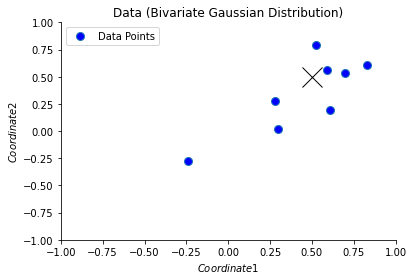

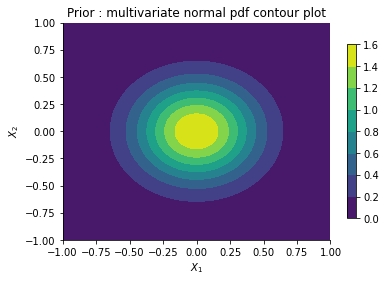

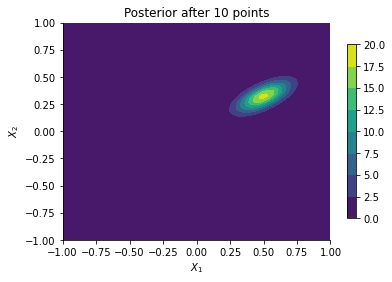

In [12]:
data = {}
prior = {}
post = {} 
key = jax.random.PRNGKey(5)

n_points=10 # number of sample data points

#Part A
z = jnp.array([0.5,0.5])
sigma_data = 0.1 * jnp.array([[2, 1], [1, 1]])

data["mu"] = z
data["Sigma"] = sigma_data
sample_points = gaussSample(data["mu"], data["Sigma"], n_points,key)
make_graph(sample_points,z,'gauss_infer_2d_(a)_latexified','Data (Bivariate Gaussian Distribution)')

#Part B
xyrange = jnp.array([[-1, 1], [-1, 1]])
npoints = 100j
prior["mu"] = jnp.array([0, 0])
prior["Sigma"] = 0.1 * jnp.eye(2)
mesh = jnp.mgrid[xyrange[0, 0] : xyrange[0, 1] : npoints, xyrange[1, 0] : xyrange[1, 1] : npoints]
x1, x2 = mesh[0], mesh[1]
points = jnp.vstack([jnp.ravel(x1), jnp.ravel(x2)]).T
prior_pdf = multivariate_normal.pdf(points, mean=prior["mu"], cov=prior["Sigma"]).reshape(x1.shape[0], x2.shape[0])

make_graph2(x1,x2,prior_pdf,'gauss_infer_2d_(b)_latexified','Prior : multivariate normal pdf contour plot')

#Part C
data_after_n = sample_points[: n_points, :]
n = n_points
s0 = prior["Sigma"]
s0_inv = inv(s0)
s = sigma_data
s_inv = inv(s)
s_n = inv(s0_inv + n * s_inv )
mu0 = prior["mu"]
mean = jnp.mean(data_after_n, 0)
mu_n =jnp.dot(s_n, (jnp.dot(n, jnp.dot(s_inv , mean)) + jnp.dot(s0_inv, mu0)))
post["mu"] = mu_n
post["Sigma"] = s_n
post_pdf = multivariate_normal.pdf(points, mean=post["mu"], cov=post["Sigma"]).reshape(x1.shape[0], x2.shape[0])
make_graph2(x1,x2,post_pdf,'gauss_infer_2d_(c)_latexified','Posterior after '+str(n)+' points')


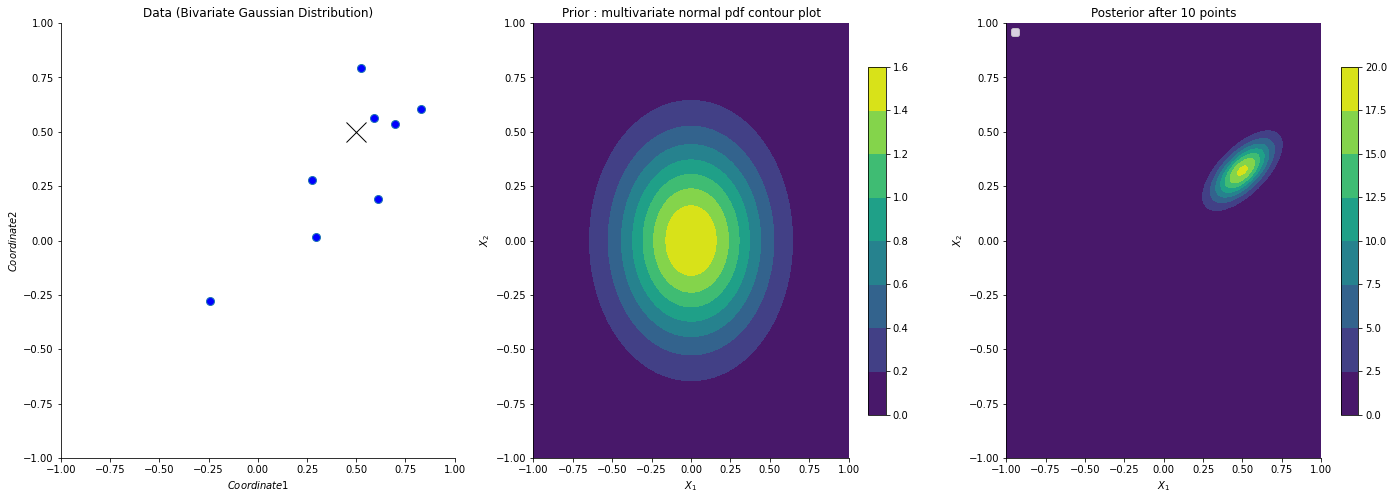

In [13]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(24,8))
make_graph(sample_points,z,'','Data (Bivariate Gaussian Distribution)',fig=fig,ax=ax1)
make_graph2(x1,x2,prior_pdf,'','Prior : multivariate normal pdf contour plot',fig=fig,ax=ax2)
make_graph2(x1,x2,post_pdf,'','Posterior after '+str(n)+' points',fig=fig,ax=ax3)
plt.show()

In [14]:
from ipywidgets import interact

@interact(random_state=(1, 10),n_=(1,20))
def generate_random(random_state,n_=10):
    key = jax.random.PRNGKey(random_state)
    sample_points = gaussSample(data["mu"], data["Sigma"], n_,key)
    make_graph(sample_points,z,'','Data (Bivariate Gaussian Distribution)')
    plt.show()


interactive(children=(IntSlider(value=5, description='random_state', max=10, min=1), IntSlider(value=10, descr…